In [1]:
import numpy as np
import pandas as pd

import os
import math
import time
import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

# Below libraries are for text processing using NLTK
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Below libraries are for feature representation using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Below libraries are for similarity matrices using sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

In [6]:
import pandas as pd

df_features = pd.read_excel("/content/news_share_data.xlsx")
df_features.sample(3)


,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
710,7026206,Can 'Stephen Colbert' Transition to Stephen Co...,There have been brands that rebranded themselv...,2014-04-12,0.573770,10,2,0,4.770302,8,...,3599.783,2314.170,654.0,0.507028,0.097910,0.037123,0.018561,0.0,0.0,3100
832,6646745,Gmail Makes Sending Mobile Photos Much Easier,Google users who back up their smartphone and ...,2014-04-15,0.541152,16,11,0,4.624254,8,...,3938.361,3179.351,17300.0,0.492690,0.153348,0.047714,0.013917,0.0,0.0,6800
121,7013217,NYT Now: All the News That Fits on Your Mobile...,As someone old enough to remember life before ...,2014-04-02,0.301168,15,2,0,4.421971,7,...,4675.052,3036.964,0.0,0.477565,0.072323,0.039014,0.020192,0.0,0.0,8600


In [7]:
df_features.shape

(1003, 22)

In [8]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1003 entries, 0 to 1002
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   article_id                  1003 non-null   int64         
 1   title                       1003 non-null   object        
 2   text                        1003 non-null   object        
 3   published_date              1003 non-null   datetime64[ns]
 4   unique_tokens_rate          1003 non-null   float64       
 5   num_hrefs                   1003 non-null   int64         
 6   num_imgs                    1003 non-null   int64         
 7   num_videos                  1003 non-null   int64         
 8   average_token_length        1003 non-null   float64       
 9   num_keywords                1003 non-null   int64         
 10  data_channel                1003 non-null   object        
 11  min_avg_key                 1003 non-null   float64     

In [9]:
df_features.columns

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')

In [10]:
cols_to_treat = ['unique_tokens_rate', 'num_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'min_avg_key',
       'max_avg_key', 'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares']

In [11]:
print("\nDistribution (BEFORE outlier treatment):")
display(df_features[cols_to_treat].describe())


Distribution (BEFORE outlier treatment):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,0.526890,11.720837,5.188435,1.215354,4.603757,7.206381,1131.437972,6463.258234,3359.478830,13518.302031,0.446724,0.106187,0.038169,0.017772,0.292537,0.057536,4247.304088
std,0.118793,15.181597,8.495002,4.079730,0.701756,1.856713,1181.134621,7455.421154,1467.674637,51499.106509,0.109167,0.092496,0.015673,0.010557,0.325227,0.266609,22609.634435
min,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.000000,-0.300000,0.000000,0.000000,0.000000,-1.000000,58.000000
25%,0.466751,4.000000,1.000000,0.000000,4.490363,6.000000,0.000000,3613.040000,2533.297000,1300.000000,0.395575,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533118,8.000000,2.000000,0.000000,4.685484,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102579,0.037325,0.016266,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.855388,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.163183,0.046922,0.022597,0.500000,0.150000,3100.000000
max,0.867925,162.000000,84.000000,51.000000,7.218430,10.000000,3613.040000,102200.000000,17604.270000,663600.000000,0.875000,0.489623,0.120805,0.103030,1.000000,1.000000,663600.000000


In [12]:
# Outlier treatment using IQR method
def treat_outliers_iqr(df_features, col):
    q1 = df_features[col].quantile(0.25)
    q3 = df_features[col].quantile(0.75)
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    df_features[col] = df_features[col].clip(lower=lower_bound, upper=upper_bound) #clipping every outliers
    return df_features

for col in cols_to_treat:
    df_features = treat_outliers_iqr(df_features, col)

print("\nDistribution (after outlier treatment using IQR method):")
display(df_features[cols_to_treat].describe())



Distribution (after outlier treatment using IQR method):


,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,min_avg_key,max_avg_key,avg_avg_key,href_avg_shares,global_subjectivity,global_sentiment_polarity,global_rate_positive_words,global_rate_negative_words,title_subjectivity,title_sentiment_polarity,shares
count,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000,1003.000000
mean,0.531859,10.165503,4.276171,0.546361,4.674528,7.206381,1131.437972,5500.831838,3257.832968,4973.773856,0.450429,0.106630,0.037995,0.017418,0.292537,0.056724,2368.839482
std,0.099559,7.667786,5.114117,0.806098,0.284026,1.856713,1181.134621,2235.712305,1049.461076,5255.894698,0.091453,0.087881,0.015002,0.009342,0.325227,0.170666,1813.311973
min,0.271954,0.000000,0.000000,0.000000,3.942827,2.000000,0.000000,3568.870000,1360.101000,0.000000,0.224677,-0.114996,0.001255,0.000000,0.000000,-0.225000,58.000000
25%,0.466751,4.000000,1.000000,0.000000,4.490363,6.000000,0.000000,3613.040000,2533.297000,1300.000000,0.395575,0.051911,0.028655,0.011224,0.000000,0.000000,1000.000000
50%,0.533118,8.000000,2.000000,0.000000,4.685484,7.000000,984.066700,4635.807000,3004.755000,2766.667000,0.455990,0.102579,0.037325,0.016266,0.200000,0.000000,1600.000000
75%,0.596615,14.000000,7.000000,1.000000,4.855388,9.000000,2116.714500,6561.910000,3809.005000,7341.000000,0.509508,0.163183,0.046922,0.022597,0.500000,0.150000,3100.000000
max,0.791412,29.000000,16.000000,2.500000,5.402925,10.000000,3613.040000,10985.215000,5722.567000,16402.500000,0.680405,0.330090,0.074322,0.039657,1.000000,0.375000,6250.000000


In [13]:
print(df_features[cols_to_treat].dtypes)


unique_tokens_rate            float64
num_hrefs                       int64
num_imgs                        int64
num_videos                    float64
average_token_length          float64
num_keywords                    int64
min_avg_key                   float64
max_avg_key                   float64
avg_avg_key                   float64
href_avg_shares               float64
global_subjectivity           float64
global_sentiment_polarity     float64
global_rate_positive_words    float64
global_rate_negative_words    float64
title_subjectivity            float64
title_sentiment_polarity      float64
shares                          int64
dtype: object


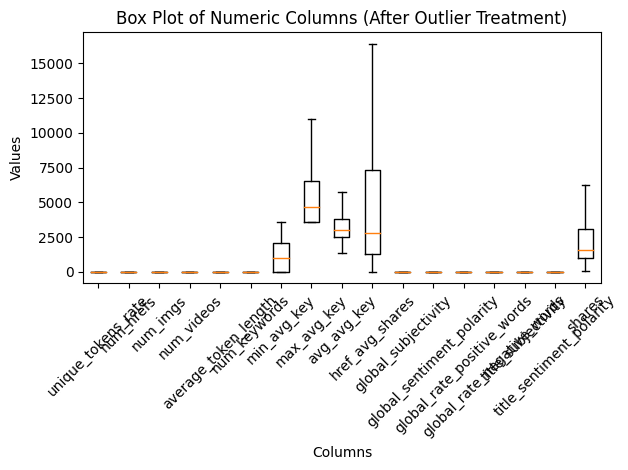

In [14]:
import matplotlib.pyplot as plt

plt.boxplot(df_features[cols_to_treat])

plt.xticks(range(1, len(cols_to_treat) + 1), cols_to_treat, rotation=45)

plt.title('Box Plot of Numeric Columns (After Outlier Treatment)')
plt.xlabel('Columns')
plt.ylabel('Values')

plt.tight_layout()
plt.show()


In [17]:
import pandas as pd

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Assuming 'published_date' is the column containing date information
# Extract month and weekday from 'published_date'
df_features['published_date'] = pd.to_datetime(df_features['published_date'])
df_features['month_no'] = df_features['published_date'].dt.month
df_features['weekday_no'] = df_features['published_date'].dt.weekday

# Display a sample of the DataFrame with the new columns
print(df_features[['published_date', 'month_no', 'weekday_no']].sample(3))



Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares'],
      dtype='object')
    published_date  month_no  weekday_no
866     2014-04-15         4           1
218     2014-04-03         4           3
840     2014-04-15         4           1


In [20]:
import pandas as pd

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Assuming 'published_date' is the column containing date information
# Extract month and weekday from 'published_date'
df_features['published_date'] = pd.to_datetime(df_features['published_date'])
df_features['month_no'] = df_features['published_date'].dt.month
df_features['weekday_no'] = df_features['published_date'].dt.weekday
df_features['is_weekend'] = (df_features['weekday_no'] >= 5).astype(int)

# Group by 'weekday_no', 'is_weekend', and 'data_channel' for mean shares
df_features['avg_shares_daily'] = df_features.groupby('weekday_no')['shares'].transform('mean')
df_features['avg_shares_weekly'] = df_features.groupby('is_weekend')['shares'].transform('mean')
df_features['avg_shares_by_channel'] = df_features.groupby('data_channel')['shares'].transform('mean')

# Display a sample of the DataFrame with the new columns
print(df_features[['weekday_no', 'is_weekend', 'data_channel', 'avg_shares_daily', 'avg_shares_weekly', 'avg_shares_by_channel']].sample(3))




Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly'],
      dtype='object')
     weekday_no  is_weekend   data_channel  avg_shares_daily  \
244           4           0      Lifestyle       2444.348214   
379           0           0  Entertainment       2441.637795   
799           0           0          00000       2441.637795   

     avg_shares_weekly  avg_shares_by_channel  
244        2285.122631            2448.313725  
379        2285.122631            2139.983784  
799        2285.122631            220

In [24]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize

# Download the 'punkt' resource
nltk.download('punkt')

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Assuming 'published_date' is the column containing date information
# Extract month and weekday from 'published_date'
df_features['published_date'] = pd.to_datetime(df_features['published_date'])
df_features['month_no'] = df_features['published_date'].dt.month
df_features['weekday_no'] = df_features['published_date'].dt.weekday
df_features['is_weekend'] = (df_features['weekday_no'] >= 5).astype(int)

# Group by 'weekday_no', 'is_weekend', and 'data_channel' for mean shares
df_features['avg_shares_daily'] = df_features.groupby('weekday_no')['shares'].transform('mean')
df_features['avg_shares_weekly'] = df_features.groupby('is_weekend')['shares'].transform('mean')
df_features['avg_shares_by_channel'] = df_features.groupby('data_channel')['shares'].transform('mean')

# Assuming 'title' and 'text' are the correct column names
def count_tokens(text):
    tokens = word_tokenize(text)
    return len(tokens)

# Apply the count_tokens function to create new columns
df_features['title_tokens'] = df_features['title'].apply(count_tokens)
df_features['text_tokens'] = df_features['text'].apply(count_tokens)

# Display the relevant columns
print(df_features[['title', 'text', 'title_tokens', 'text_tokens']])



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly',
       'avg_shares_by_channel'],
      dtype='object')
                                                  title  \
0                    It's Time for a YouTube Competitor   
1     The Ultimate Roundup of 2014's Biggest April F...   
2     A Selfie and One Garish Jacket: How the Red So...   
3       African Telecom Proposes More Diverse Emoticons   
4     Google to Launch Improved Android Camera App, ...   
...                                                 

In [25]:
df_features.sample(4)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,title_sentiment_polarity,shares,month_no,weekday_no,is_weekend,avg_shares_daily,avg_shares_weekly,avg_shares_by_channel,title_tokens,text_tokens
805,6863759,Amazon Unintentionally Created a Shopping List...,"One day, some drug dealer bought a particular ...",2014-04-15,0.547541,6,2,0.0,4.718654,6,...,0.000000,1500,4,1,0,2231.880184,2285.122631,2208.388571,9,626
468,7009263,Next 'Super Smash Bros.' Coming to 3DS in Summ...,Nintendo's next iteration of the popular Super...,2014-04-08,0.514760,22,1,1.0,4.640071,5,...,0.000000,3100,4,1,0,2231.880184,2285.122631,3106.109091,15,447
838,7004748,Stop Treating Introversion Like a Trend,I am guilty of blogging away my anger and tear...,2014-04-15,0.484234,7,3,0.0,4.840807,6,...,0.136364,5800,4,1,0,2231.880184,2285.122631,2689.651515,6,1779
193,7012293,"Intel Braswell Chip Will Land in Low-Cost PCs,...",Intel's new processor -- code-named Braswell -...,2014-04-03,0.452991,28,1,0.0,4.795734,5,...,0.000000,629,4,3,0,2299.591549,2285.122631,2208.388571,10,274


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly',
       'avg_shares_by_channel', 'title_tokens', 'text_tokens'],
      dtype='object')


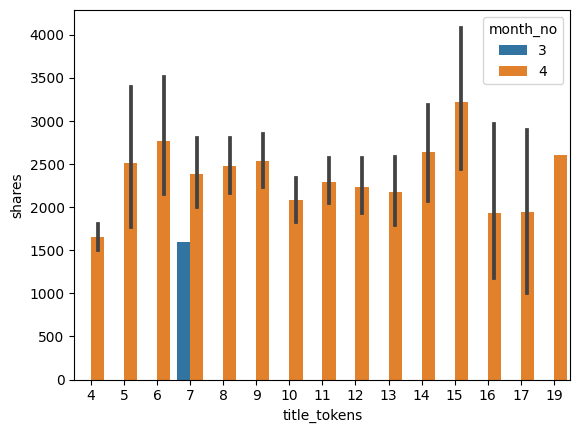

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Replace "month" with the correct column name, for example, "month_no"
sns.barplot(data=df_features, x="title_tokens", y="shares", hue="month_no")

# Show the plot
plt.show()


Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly',
       'avg_shares_by_channel', 'title_tokens', 'text_tokens'],
      dtype='object')


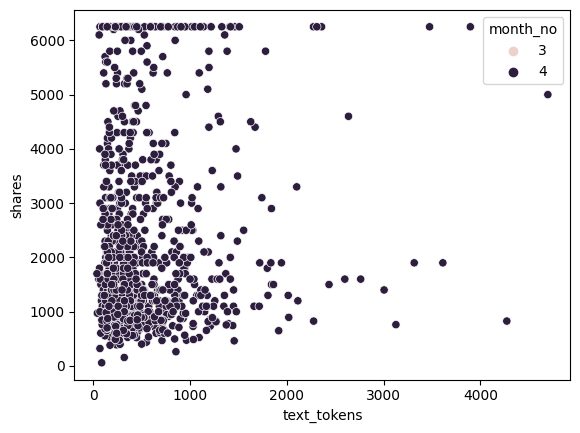

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Replace "month" with the correct column name, for example, "month_no"
sns.scatterplot(data=df_features, x='text_tokens', y='shares', hue='month_no')

# Show the plot
plt.show()


In [32]:
import re
from wordcloud import WordCloud
import nltk
from sklearn.feature_extraction.text import CountVectorizer

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly',
       'avg_shares_by_channel', 'title_tokens', 'text_tokens'],
      dtype='object')


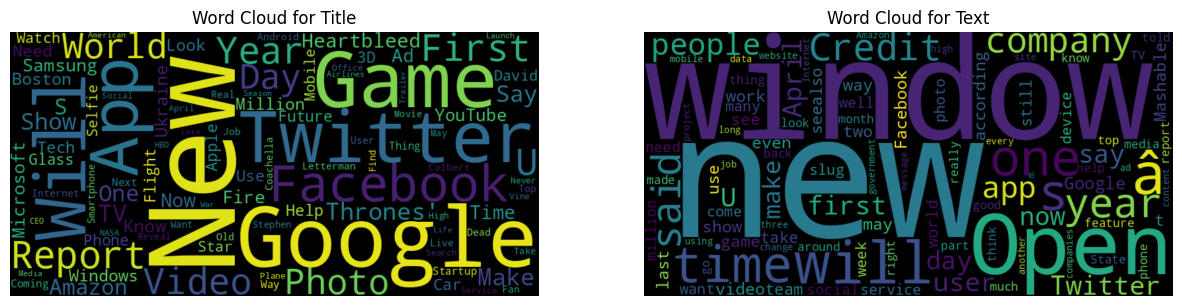

In [36]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Assuming 'title' and 'text' are the correct column names
textw_title = " ".join(sent for sent in df_features['title'])
wordcloud_title = WordCloud(width=800, height=400, background_color='black', collocations=False, max_words=100).generate(textw_title)

textw_text = " ".join(sent for sent in df_features['text'])
wordcloud_text = WordCloud(width=800, height=400, background_color='black', collocations=False, max_words=100).generate(textw_text)

# Display word clouds for title and text separately
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Title')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.title('Word Cloud for Text')
plt.axis('off')

plt.show()




## 3.2 Wordcloud of the text column

Index(['article_id', 'title', 'text', 'published_date', 'unique_tokens_rate',
       'num_hrefs', 'num_imgs', 'num_videos', 'average_token_length',
       'num_keywords', 'data_channel', 'min_avg_key', 'max_avg_key',
       'avg_avg_key', 'href_avg_shares', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
       'global_rate_negative_words', 'title_subjectivity',
       'title_sentiment_polarity', 'shares', 'month_no', 'weekday_no',
       'is_weekend', 'avg_shares_daily', 'avg_shares_weekly',
       'avg_shares_by_channel', 'title_tokens', 'text_tokens'],
      dtype='object')


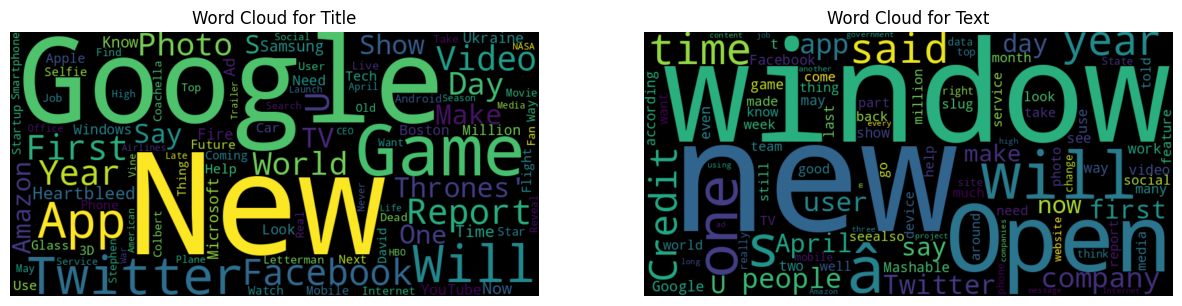

In [39]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame from the Excel file
# df_features = pd.read_excel("/content/news_share_data.xlsx")

# Check column names and remove leading/trailing whitespaces
df_features.columns = df_features.columns.str.strip()
print(df_features.columns)

# Assuming 'title' and 'text' are the correct column names
textw_title = " ".join(sent for sent in df_features['title'])
wordcloud_title = WordCloud(width=800, height=400, background_color='black', collocations=False, max_words=100).generate(textw_title)

textw_text = " ".join(sent for sent in df_features['text'])
wordcloud_text = WordCloud(width=800, height=400, background_color='black', collocations=False, max_words=100).generate(textw_text)

# Display word clouds for title and text separately
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_title, interpolation='bilinear')
plt.title('Word Cloud for Title')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_text, interpolation='bilinear')
plt.title('Word Cloud for Text')
plt.axis('off')

plt.show()


In [40]:
import nltk
from nltk import pos_tag

from collections import Counter


In [41]:
def count_and_classify_pos_tags(text):
    words = word_tokenize(text)  # Tokenizing the text
    pos_tags = pos_tag(words)    # Applying POS tagging

    # Counts
    noun_count = 0
    verb_count = 0
    adjective_count = 0

    # Iterating through POS tags and classifying them
    for word, tag in pos_tags:
        if tag.startswith('NN'):
            noun_count += 1
        elif tag.startswith('VB') or tag == 'RB' or tag == 'MD':  # Verbs and adverbs and modals
            verb_count += 1
        elif tag.startswith('JJ'):
            adjective_count += 1

    return {
        'noun_count': noun_count,
        'verb_count': verb_count,
        'adjective_count': adjective_count
    }

In [42]:
df_features.head(3)

,article_id,title,text,published_date,unique_tokens_rate,num_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,title_sentiment_polarity,shares,month_no,weekday_no,is_weekend,avg_shares_daily,avg_shares_weekly,avg_shares_by_channel,title_tokens,text_tokens
0,7014291,It's Time for a YouTube Competitor,It was reported last week that Yahoo is gettin...,2014-03-31,0.640816,5,3,1.0,4.579592,5,...,0.25,1600,3,0,0,2441.637795,2285.122631,2310.134146,7,195
1,7014327,The Ultimate Roundup of 2014's Biggest April F...,April Fools' marks the day when pranking goes ...,2014-04-01,0.549618,4,1,0.0,4.636704,7,...,0.00,1500,4,1,0,2231.880184,2285.122631,2689.651515,12,108
2,7014304,A Selfie and One Garish Jacket: How the Red So...,The 2013 World Series champion Boston Red Sox ...,2014-04-01,0.577236,8,1,0.0,4.627451,7,...,0.00,1400,4,1,0,2231.880184,2285.122631,2689.651515,15,517


In [44]:
from sklearn.feature_extraction.text import CountVectorizer

def Ngrams_extraction(descriptions):
    # Fill missing values with an empty string
    descriptions = descriptions.fillna('')

    vectorizer = CountVectorizer(ngram_range=(2, 2), max_features=7)
    X = vectorizer.fit_transform(descriptions)
    ngram_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
    return ngram_df

ngram_title_df = Ngrams_extraction(df_features['title'])
ngram_txt_df = Ngrams_extraction(df_features['text'])


In [ ]:
ngram_title_df.head(5)

,amazon fire,april fools,fire tv,game thrones,google glass,need know,report says
0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1


In [ ]:
ngram_txt_df.head(5)

,2014opens new,april 2014opens,fire tv,new window,new york,see also,social media
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0
2,5,5,0,17,0,0,0
3,0,0,0,2,0,1,0
4,0,0,0,1,0,0,0


In [45]:
df_features.shape

(1003, 30)